# Training Image Classification Models Based on Classical Network Architecture

## Steps
### Data preprocessing section:

 - Data enhancement: the transforms module in torchvision comes with its own function, which is more practical.
 - Data preprocessing: the transforms module in torchvision also helps us to realize it, so we can call it directly.
 - DataLoader module reads batch data directly.

### DataLoader module reads batch data directly:

 - Load the pre-training model, torchvision has a lot of classic network architecture, it's very convenient to call, and you can use other people's well-trained weight parameters to continue training, which is also known as migration learning.
 - It is important to note that other people's trained tasks are not exactly the same as ours, we need to change the last head layer, usually the last fully connected layer, into our own task.
 - When training, we can re-train all the layers, or we can only train the last layer of our task, because the first few layers are for feature extraction, and the essential goal of the task is the same.

### Network model saving and testing:
 - The model can be saved selectively, for example, in the validation set, if the current effect is good, then save the model.
 - Read the model for actual testing.

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

## Data reading and pre-processing operations

In [2]:
data_dir = './flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

## Make a good data source:
- All image preprocessing operations are specified in data_transforms
- ImageFolder assumes that all files are stored in folders, and that each folder contains images of the same category, with the name of the folder being the name of the category.

In [3]:
data_transforms = {
    'train': 
        transforms.Compose([
        transforms.Resize([96, 96]), # Uniform image size
        # Data Augmentation
        transforms.RandomRotation(45),# Random rotation, randomly selected between -45 and 45 degrees
        transforms.CenterCrop(64),# Trimming from the center
        transforms.RandomHorizontalFlip(p=0.5),# Random Horizontal Flip Select a probability
        transforms.RandomVerticalFlip(p=0.5),# Random vertical flip
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),# Parameter 1 is Brightness, Parameter 2 is Contrast, Parameter 3 is Saturation, Parameter 4 is Hue
        transforms.RandomGrayscale(p=0.025),# The probability is converted to gray rate, and the 3-channel is R=G=B
        transforms.ToTensor(), # Converting data to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# Normalization, Mean, standard deviation
    ]),
    'valid': 
        transforms.Compose([
        transforms.Resize([64, 64]), # Ensure training and test sizes are the same
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
batch_size = 128

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=[96, 96], interpolation=bilinear, max_size=None, antialias=warn)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(64, 64))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                ToTe

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8a3ea941f0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f8a3ea94220>}

In [7]:
dataset_sizes

{'train': 6552, 'valid': 818}

## Read the actual name corresponding to the tag

In [8]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [9]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

## Load the model provided in the models, and use the trained weights as initialization parameters.

In [10]:
model_name = 'resnet'  # There are more options available ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
# Whether to use people's trained features for
feature_extract = True

In [11]:
# Whether to train with GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


### Should the model parameters be updated?
- Sometimes we use other people's models, so we use them all the time, we can decide whether to update them or not.

In [12]:
model_ft = models.resnet18()  #18 layers can be faster, better conditions can also choose 152
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Change the model output layer to your own

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft = models.resnet18(pretrained=use_pretrained) # Specify the model name
    set_parameter_requires_grad(model_ft, feature_extract) # Model parameters are not updated
    
    # Redefines the full connectivity layer
    # param.requires_grad is True
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 102) # The number of categories yourself according to your task
                            
    input_size = 64 # Input size according to your own configuration

    return model_ft, input_size

## Set which layers to train

In [16]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU or CPU Computing
model_ft = model_ft.to(device)

# Model saving, name your own
filename='best.pt'

# Whether to train all layers
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/citron/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████| 44.7M/44.7M [00:50<00:00, 919kB/s]


Params to learn:
	 fc.weight
	 fc.bias


In [17]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Optimizer settings

In [18]:
# Optimizer Settings
optimizer_ft = optim.Adam(params_to_update, lr=1e-2) # You decide what parameters you want to train.
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) # Learning rate decays to 1/10 of original every 7 epochs
criterion = nn.CrossEntropyLoss()

## Training module

In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,filename='best.pt'):
    # count time
    since = time.time()
    # Record the best one
    best_acc = 0
    # The model also has to go to your CPU or GPU
    model.to(device)
    # Print a bunch of losses and metrics during training
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    # learning rate
    LRs = [optimizer.param_groups[0]['lr']]
    # The best model of that time, which will be changed later, initialized first
    best_model_wts = copy.deepcopy(model.state_dict())
    # One epoch at a time
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training and validation
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Train
            else:
                model.eval()   # Valid

            running_loss = 0.0
            running_corrects = 0

            # Fetch all the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Put it on your CPU or GPU
                labels = labels.to(device)

                # zero
                optimizer.zero_grad()
                # Only the gradient is calculated and updated during training
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                # Updating weights during the training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Calculation of losses
                running_loss += loss.item() * inputs.size(0) # 0 means batch that dimension
                running_corrects += torch.sum(preds == labels.data)# Consistency between the largest predicted result and the true value
                
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)# arithmetic mean
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since # How much time have I wasted in one epoch?
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # Get the best model for that one.
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),# The key in the dictionary is the name of each layer and the value is the trained weights
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                # scheduler.step(epoch_loss) # Learning rate decay
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()# Learning rate decay

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # After training, use the best one as the final result of the model, and wait for a test later.
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

## Start training!
- We have now trained only the output layer

In [20]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
Time elapsed 1m 8s
train Loss: 4.0515 Acc: 0.2379
Time elapsed 1m 15s
valid Loss: 3.6263 Acc: 0.2567
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 2m 24s
train Loss: 2.8754 Acc: 0.3964
Time elapsed 2m 31s
valid Loss: 3.5431 Acc: 0.2983
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 3m 38s
train Loss: 2.7854 Acc: 0.4238
Time elapsed 3m 46s
valid Loss: 3.6176 Acc: 0.3093
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 4m 53s
train Loss: 2.8043 Acc: 0.4280
Time elapsed 5m 0s
valid Loss: 3.8073 Acc: 0.3068
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 6m 8s
train Loss: 2.6920 Acc: 0.4464
Time elapsed 6m 15s
valid Loss: 3.9726 Acc: 0.3081
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 7m 22s
train Loss: 2.6653 Acc: 0.4621
Time elapsed 7m 29s
valid Loss: 3.9234 Acc: 0.3117
Optimizer learning rate : 0.0100000

Epoch 6/19
----------
Time elapsed 8m

## And then continue to train all the layers

In [21]:
for param in model_ft.parameters():
    param.requires_grad = True

# Continue training all the parameters again, with the learning rate turned down a bit
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# loss function
criterion = nn.CrossEntropyLoss()

In [22]:
# Load the previously trained weight parameters

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [23]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=10,)

Epoch 0/9
----------
Time elapsed 1m 49s
train Loss: 2.7842 Acc: 0.4144
Time elapsed 1m 57s
valid Loss: 2.9832 Acc: 0.3851
Optimizer learning rate : 0.0010000

Epoch 1/9
----------
Time elapsed 3m 52s
train Loss: 1.5369 Acc: 0.5957
Time elapsed 3m 60s
valid Loss: 1.8990 Acc: 0.5000
Optimizer learning rate : 0.0010000

Epoch 2/9
----------
Time elapsed 5m 49s
train Loss: 1.1239 Acc: 0.6864
Time elapsed 5m 56s
valid Loss: 1.8231 Acc: 0.5403
Optimizer learning rate : 0.0010000

Epoch 3/9
----------
Time elapsed 7m 46s
train Loss: 1.0093 Acc: 0.7199
Time elapsed 7m 54s
valid Loss: 1.9133 Acc: 0.5208
Optimizer learning rate : 0.0010000

Epoch 4/9
----------
Time elapsed 9m 44s
train Loss: 0.8692 Acc: 0.7524
Time elapsed 9m 52s
valid Loss: 1.8311 Acc: 0.5844
Optimizer learning rate : 0.0010000

Epoch 5/9
----------
Time elapsed 11m 42s
train Loss: 0.7637 Acc: 0.7811
Time elapsed 11m 50s
valid Loss: 2.0379 Acc: 0.5428
Optimizer learning rate : 0.0010000

Epoch 6/9
----------
Time elapsed 13m 

## Load the trained model

In [24]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU Mode
model_ft = model_ft.to(device)

# Name of the file to save
filename='best.pt'

# Loading Models
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Test data preprocessing

- The test data processing method needs to be the same as the training method. 
- The purpose of the crop operation is to ensure that the size of the input is the same.
- Normalization is also necessary, using the same mean and std as the training data, but note that the training data is normalized on 0-1, so the test data needs to be normalized first.
- Finally, the color channel is the first dimension in PyTorch, which is different from many toolkits and needs to be converted.

In [34]:
# Getting test data for a batch
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter)

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

 - output represents the likelihood that each piece of data in a batch belongs to each category.

In [35]:
output.shape

torch.Size([128, 102])

## Get the one with the highest probability

In [36]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([ 34,  89,  49,  71,  65,  49,  82,  11,  55,  59,  56,  90,  56,
        96,  57,   3,  10,  74,  89,  47,  76,  77,  33,  49,  89,  59,
        96,  73,  70,  86,   8,  43,  43,  43,  52,  76,  78,  10,  38,
        82,  19,  11,  96,  80,  35,  41,   6,  76,  55,  83,   3,  48,
        55,  11,  75,  24,  56,  62,  16,  64,  16,  59,  76,  33, 101,
        49,  61,  38,  82,  76,  55,  79,  44,  59,  39,  17,  68,  66,
        93,  49,  41,  41,  78,  49,  61,  86,  73,  98,  51,  49,  49,
        89,  59,   7,  74,   5,  57,  77,   4,  96,  53,  73,  66,  84,
        78,  28,  41,  77,  84,  39,   0,  92,  81,   3,   3,  78,  10,
        28,  60,  15,  70,  99,  78,  49,  43,  38,  49,  96])

## Demonstrate the results of the prediction

In [37]:
def im_convert(tensor):
    """ Show data """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

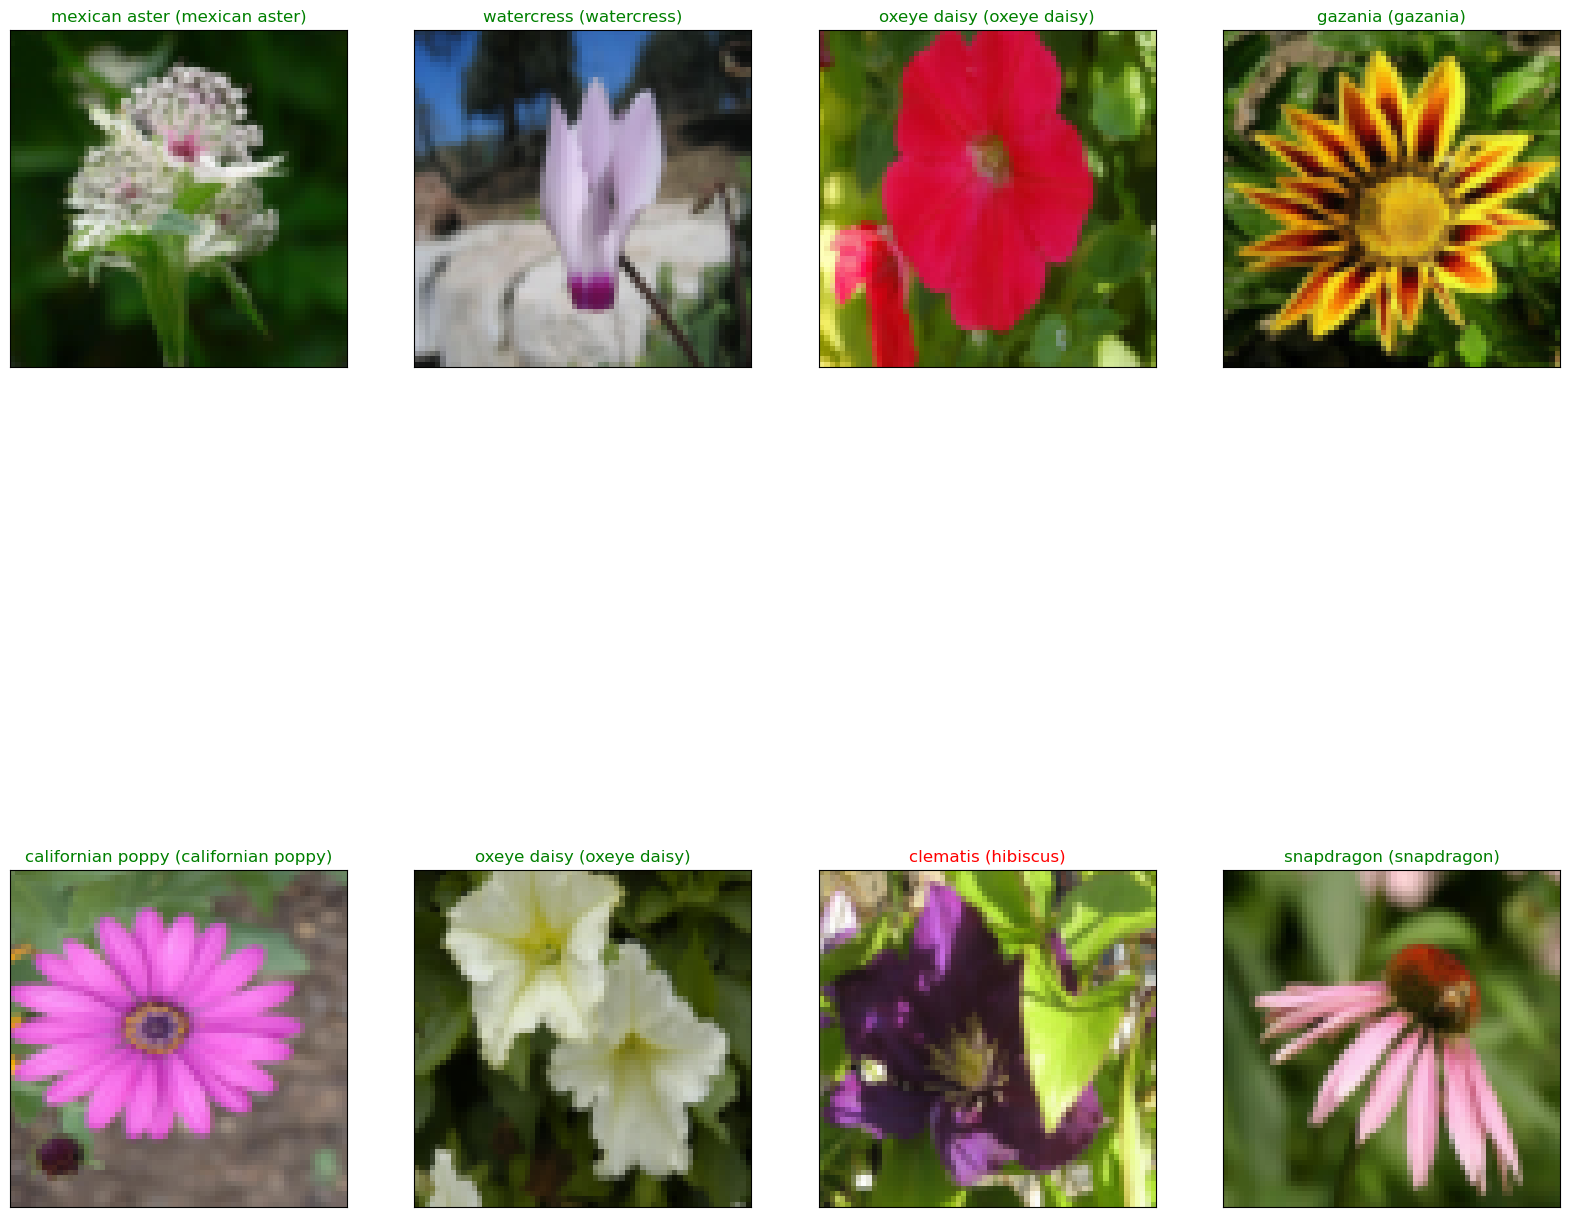

In [38]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()